In [1]:
# Import the packages we will use
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math

In [2]:
# The following directive activates inline plotting
%matplotlib inline

###### Read loops coordinates, sizes and etc

In [3]:
loops_info = pandas.read_csv('GSE63525_GM12878_primary+replicate_HiCCUPS_looplist.txt', sep='\t',
                             dtype = {'x1': np.long, 'x2': np.long, 'y1': np.long, 'y2': np.long})

###### Utilities

In [4]:
def plot_loops_on_hic_matrix(arr, resolution, loops_info, start = 0, end = -1):     
    '''
        plot loops with boundaries on a HiC map
    '''
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)

    im = ax.matshow(arr[start:end, start:end], cmap='YlOrRd')
    fig.colorbar(im)

    for index, row in loops_info.iterrows():

        # the coordinates of the upstream locus corresponding to the peak pixel
        x1 = int(row['x1']/resolution)-start-.5
        x2 = int(row['x2']/resolution)-start-.5

        # the coordinates of the downstream locus corresponding to the peak pixel
        y1 = int(row['y1']/resolution)-start+0.5
        y2 = int(row['y2']/resolution)-start+0.5

        loop_y_centroid = int(row['centroid1']/resolution) - start
        loop_x_centroid = int(row['centroid2']/resolution) - start
        loop_radius = row['radius']/resolution

        loop_center = (loop_x_centroid, loop_y_centroid)

        ## loop as a circle with center in @loop_center with radius @loop_radius
        loop = matplotlib.patches.Circle(loop_center, loop_radius,
                                         fill=None, alpha=1, edgecolor='lime', linewidth=2.0)
        ax.add_patch(loop)

        ## areas with start locus and end locus
        loop_tr = matplotlib.patches.Rectangle((x2, x1), y2-x2, y1-x1, 
                                               fill=None, alpha=1, edgecolor='black', linewidth=.5)
        ax.add_patch(loop_tr)

###### Select chromose to work with

In [5]:
chr_index = 1
chr = 'chr' + str(chr_index)
loops = loops_info[loops_info.chr1 == str(chr_index)]

### 10kb resolution

In [6]:
arr_10kb = np.load('arrs/10kb_' + str(chr_index) + 'chr_norm.npy')
arr_10kb_log = np.load('arrs/10kb_' + str(chr_index) + 'chr_norm_log.npy')
resolution = 10**4

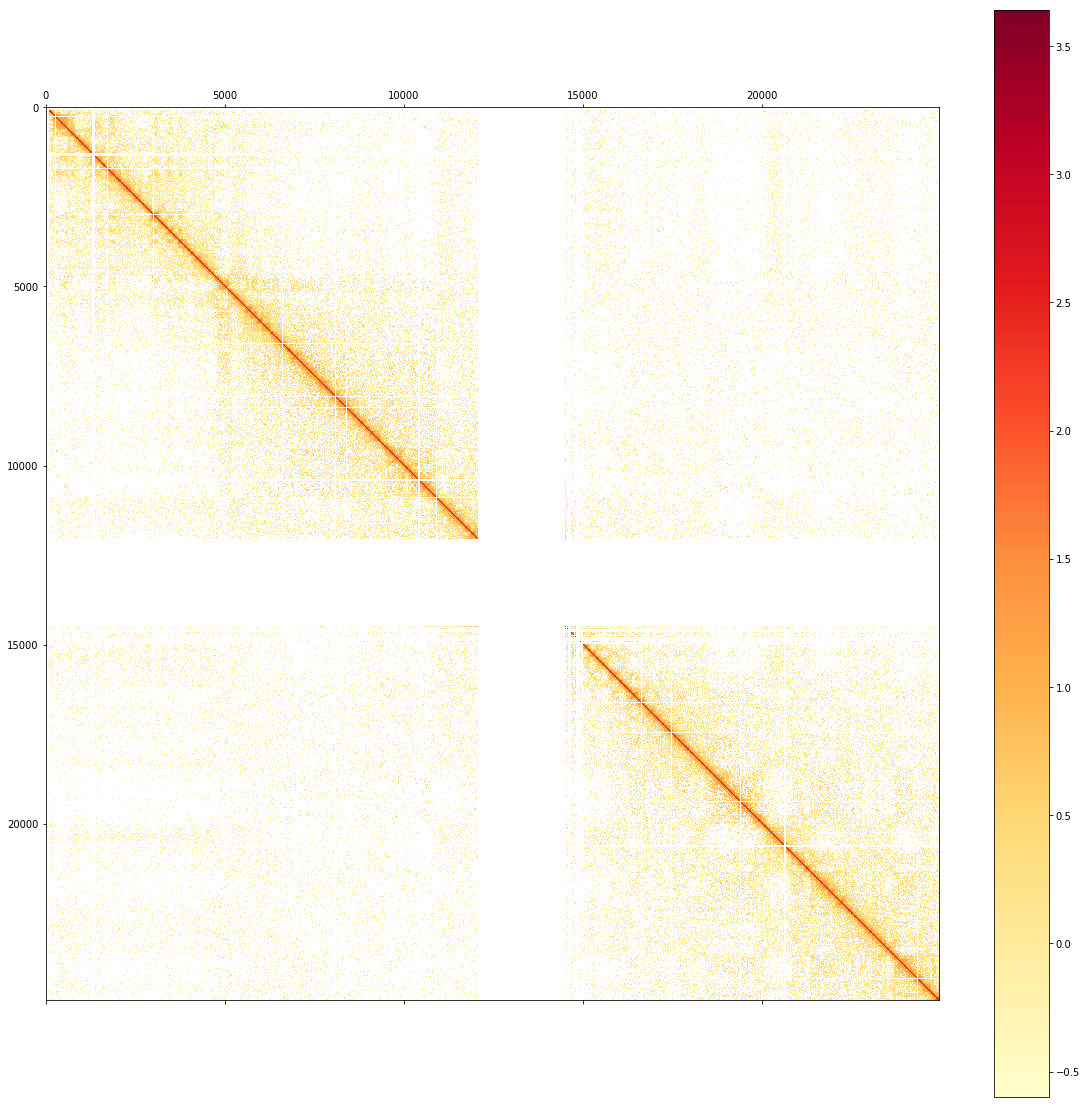

In [7]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(np.load('arrs/10kb_' + str(chr_index) + 'chr_log.npy'), cmap='YlOrRd')
fig.colorbar(im)

It divides each diagonal of a Hi-C contact map by its' mean.  
It also does it in a smart way: it calculates averages over stripes from X to X*1.05, and divides each stripe by its mean.  
It allows to avoid divergence far from the main diagonal with a very few reads.  
(comment from __mirnylib__)

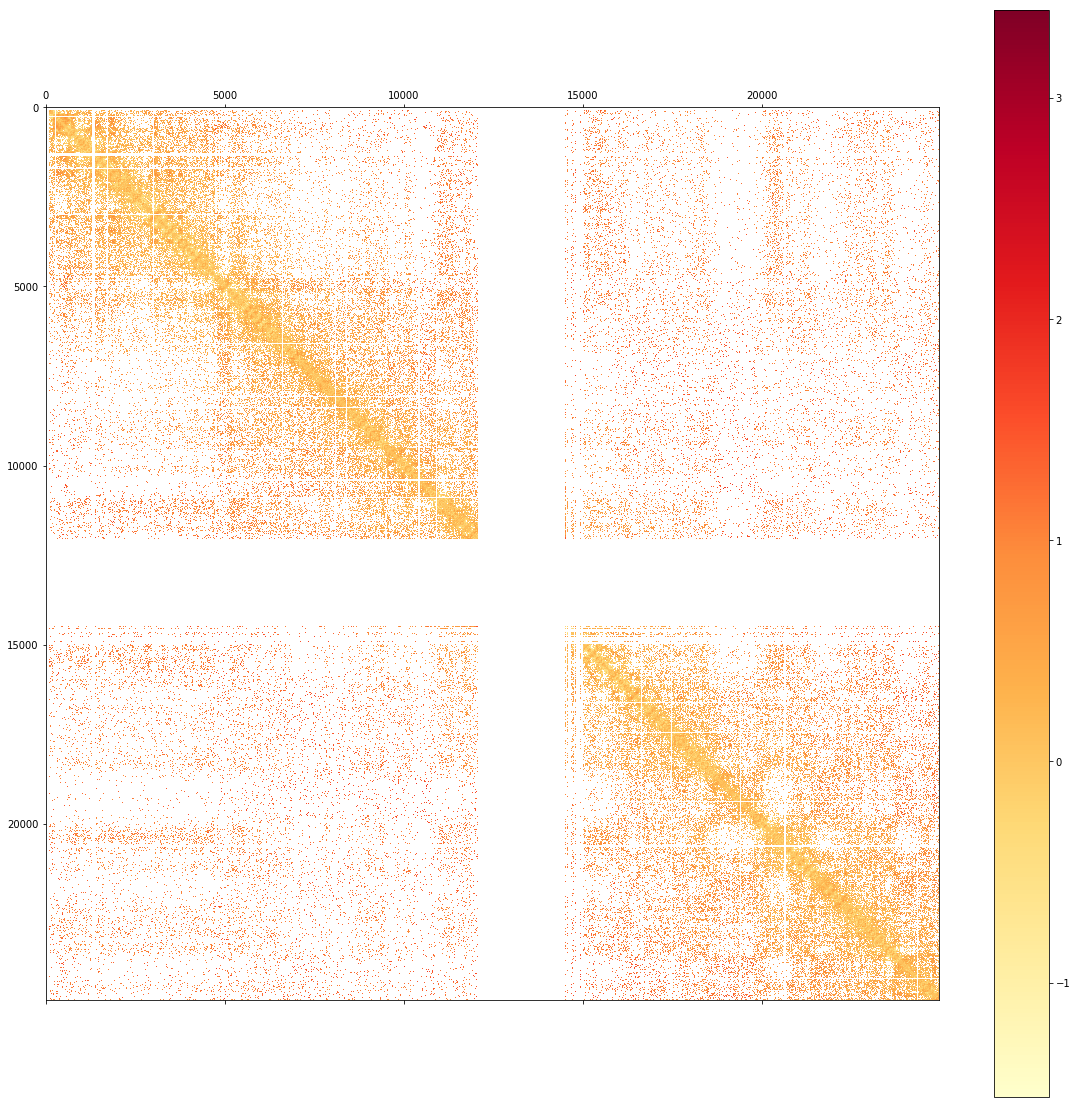

In [8]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(arr_10kb_log, cmap='YlOrRd')
fig.colorbar(im)

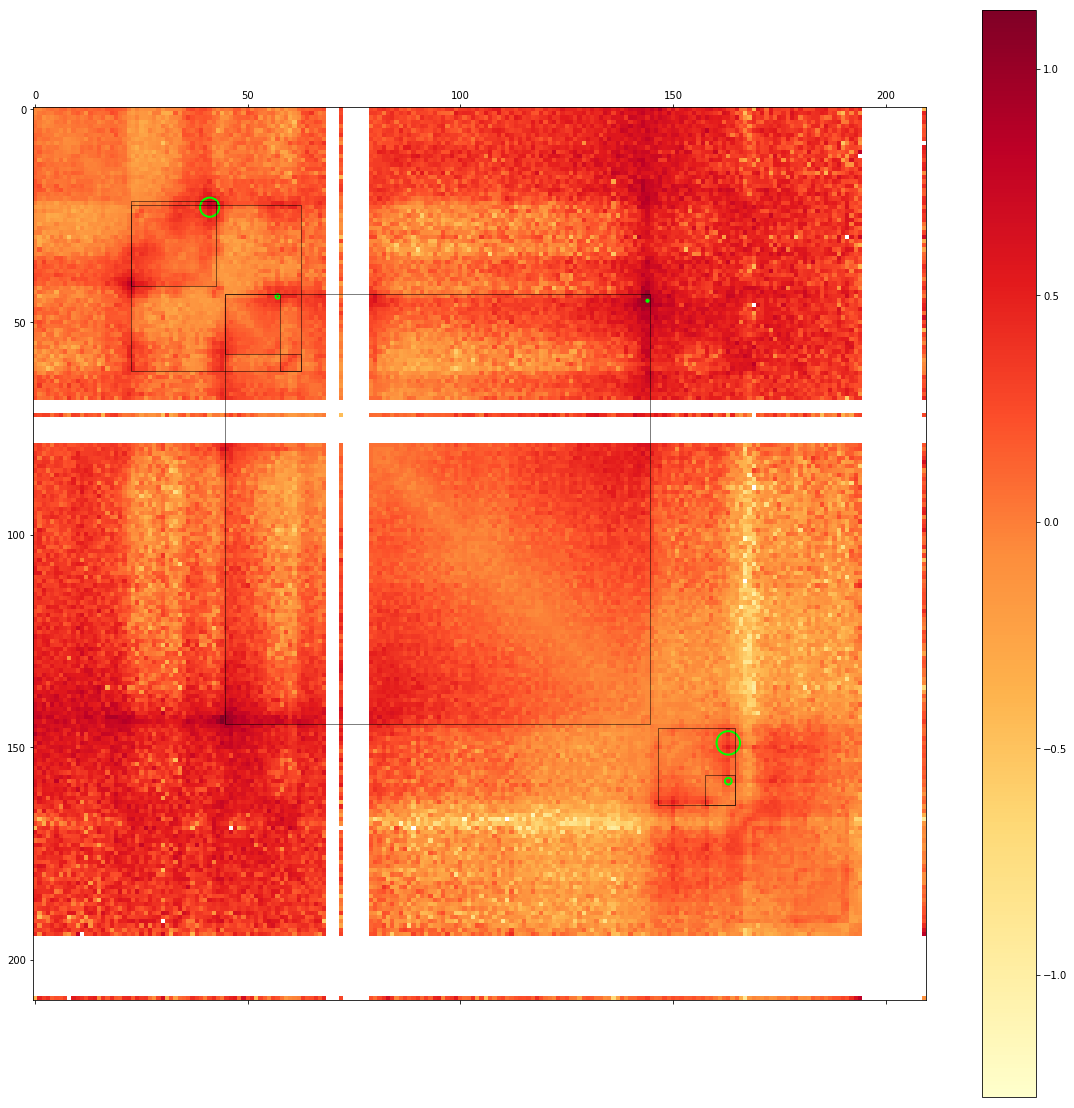

In [9]:
plot_loops_on_hic_matrix(arr_10kb_log, resolution, loops, start = 190, end = 400)

### 5kb resolution

In [10]:
arr_5kb = np.load('arrs/5kb_' + str(chr_index) + 'chr_norm.npy')
arr_5kb_log = np.load('arrs/5kb_' + str(chr_index) + 'chr_norm_log.npy')
resolution = 5 * 10**3

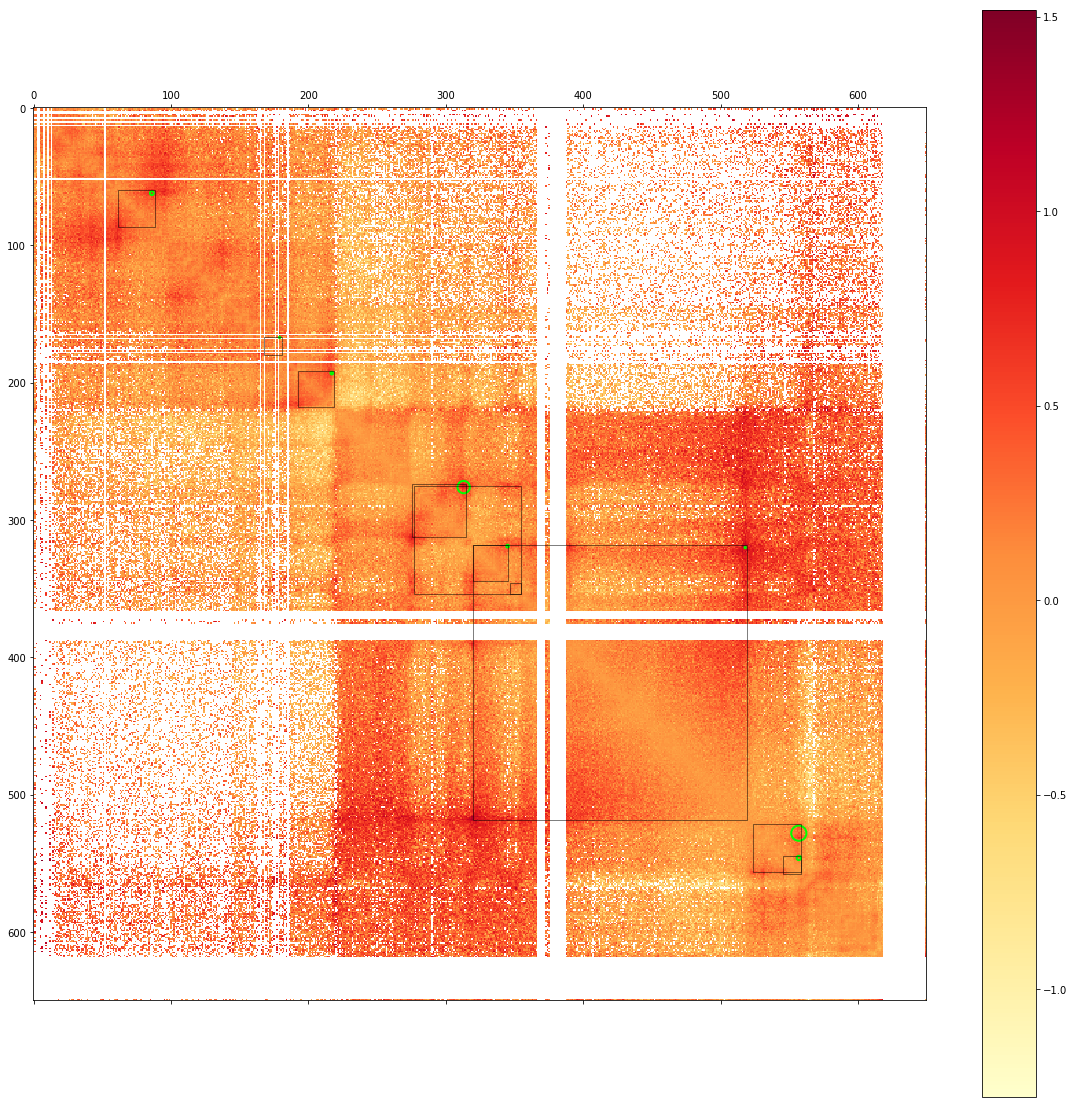

In [11]:
plot_loops_on_hic_matrix(arr_5kb_log, 5*10**3, loops, start = 150, end = 800)

### Average (summary) loop

In [12]:
def sum_loops(arr, resolution, window_size = 10):
    loop_sum = np.zeros((window_size, window_size))

    for index, row in loops.iterrows():

        loop_y_centroid = int(row.centroid1/resolution)
        loop_x_centroid = int(row.centroid2/resolution)

        loop_window = arr[loop_y_centroid-math.floor(window_size/2):loop_y_centroid+math.ceil(window_size/2),
                          loop_x_centroid-math.floor(window_size/2):loop_x_centroid+math.ceil(window_size/2)]

        loop_window[loop_window == -np.inf] = -1
        loop_sum = loop_sum + np.nan_to_num(loop_window) 
        
    return loop_sum

###### 10kb

In [13]:
resolution = 10**4

window_size = 13
loop_sum = sum_loops(arr_10kb_log, resolution, window_size)

###### Single loop

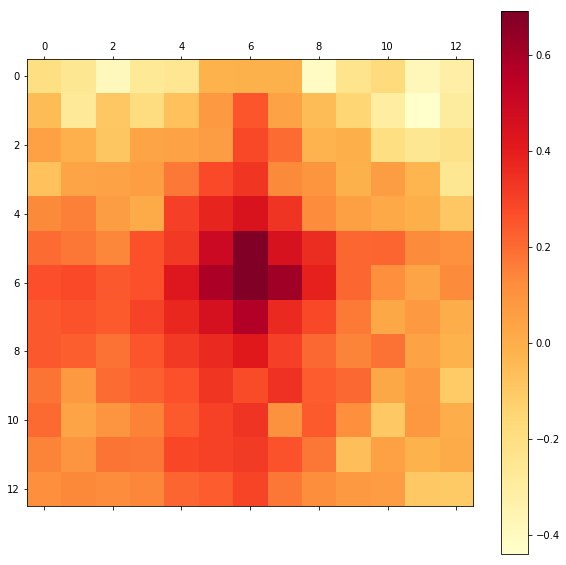

In [14]:
row = loops_info.iloc[1000]

loop_y_centroid = int(row.centroid1/resolution)
loop_x_centroid = int(row.centroid2/resolution)

loop_window = arr_10kb_log[loop_y_centroid-math.floor(window_size/2):loop_y_centroid+math.ceil(window_size/2),
                           loop_x_centroid-math.floor(window_size/2):loop_x_centroid+math.ceil(window_size/2)]

loop_window[loop_window == -np.inf] = -1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(loop_window, cmap='YlOrRd')
fig.colorbar(im)

###### Summary loop

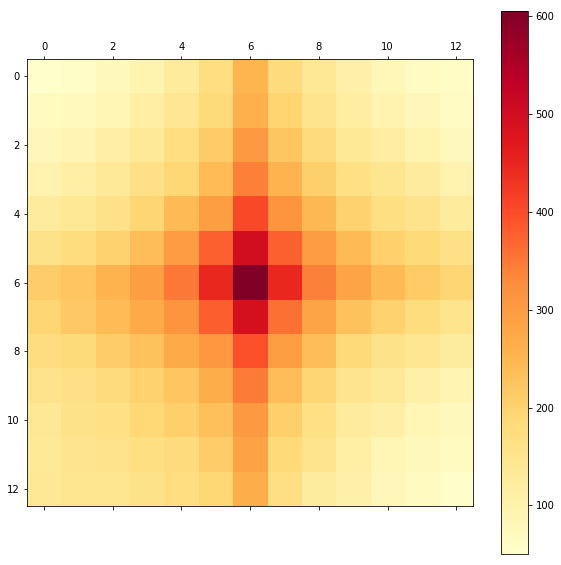

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(loop_sum, cmap='YlOrRd')
fig.colorbar(im)

### Scaling

In [16]:
def resize_image_arr(original_image, width, height):
    resize_image = np.zeros(shape=(width,height))
    for W in range(width):
        for H in range(height):
            new_width = int( W * original_image.shape[0] / width )
            new_height = int( H * original_image.shape[1] / height )
            resize_image[W][H] = original_image[new_width][new_height]
            
    return resize_image

In [17]:
loop_new_size = 100

In [18]:
width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for index, row in loops.iterrows():
        
    window = 1
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    original_image = arr_10kb_log[x1-window:y1+window, x2-window:y2+window]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = -1
    resize_image = np.nan_to_num(resize_image) 
    
    resize_image_sum = resize_image_sum + resize_image

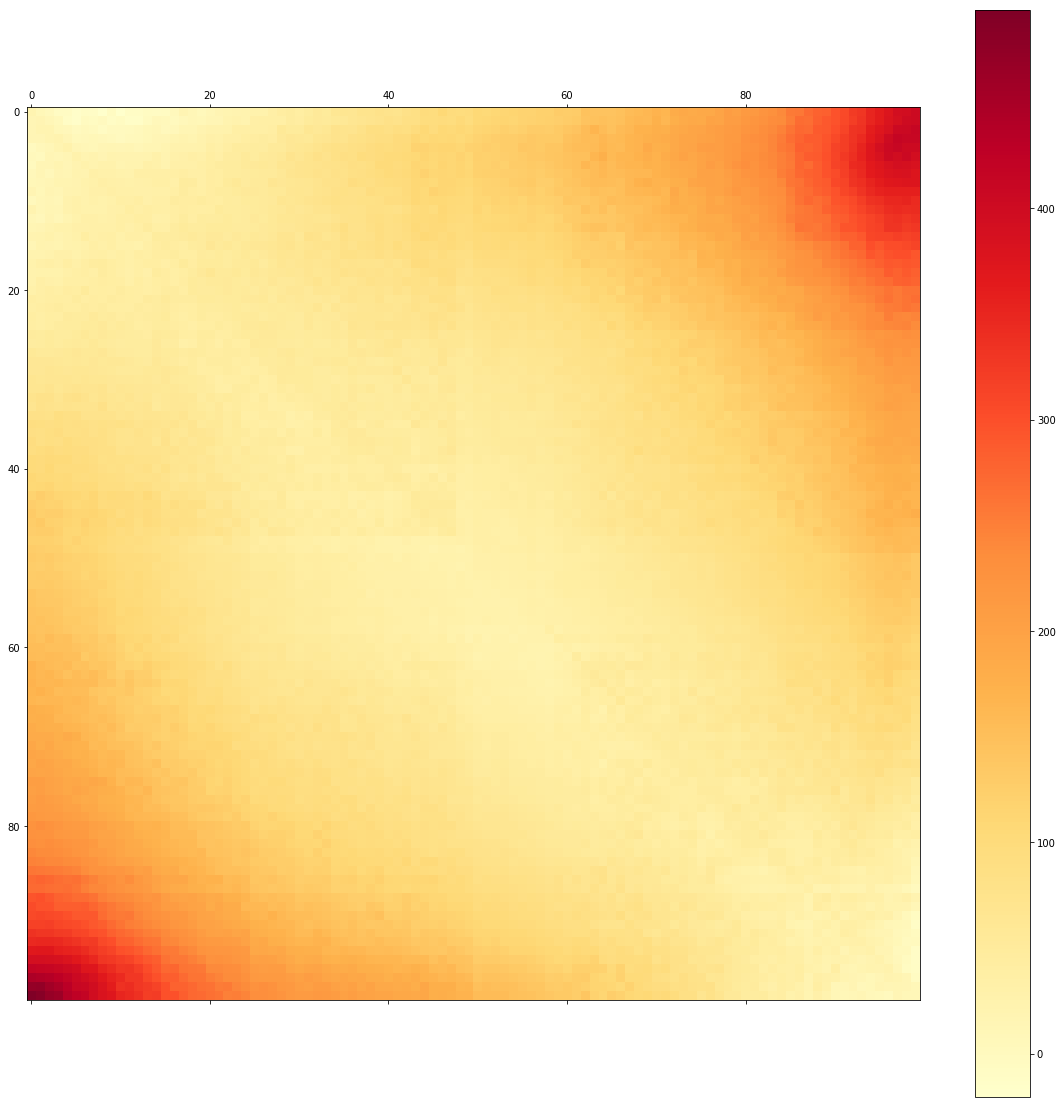

In [19]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)

im = ax.matshow(resize_image_sum, cmap='YlOrRd')
fig.colorbar(im)

#### Calculate mean contact above the distance between bins

In [20]:
def calc_densities_mean(arr):
    '''
        calculate mean of each diagonal
        mean of each diagonal corresponds for the density for each genimic size step
    '''
    density = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        density[i] = np.nanmean(np.diagonal(arr, i))
        
    return density

In [21]:
def calc_densities_sum(arr):
    '''
        calculate mean of each diagonal
        sum of each diagonal corresponds for the density for each genimic size step
    '''
    density = np.zeros(arr.shape[0])
    for i in range(arr.shape[0]):
        density[i] = np.nansum(np.diagonal(arr, i))
        
    return density

###### loops

In [22]:
arr = np.load('arrs/10kb_' + str(chr_index) + 'chr.npy')

In [23]:
densities = []

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    loop = arr_10kb[x1:y1, x2:y2]
    loop[loop == -np.inf] = 0
    
    density = calc_densities_mean(loop)
    densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


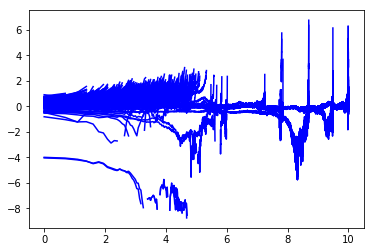

In [24]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

In [25]:
densities = []

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    loop = arr_10kb[x1:y1, x2:y2]
    loop[loop == -np.inf] = 0
    
    density = calc_densities_sum(loop)
    densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


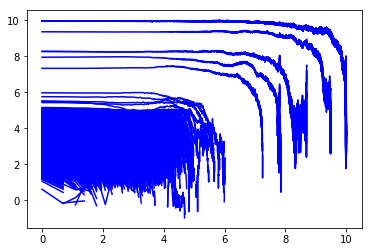

In [26]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

###### between loops

In [27]:
densities = []
        
x_begin = 0
y_begin = 0

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:
        a = arr_10kb[x_begin:x1, y_begin:y1]
        a[a == -np.inf] = 0

        x_begin = x2
        y_begin = y2

        density = calc_densities_mean(a)
        densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


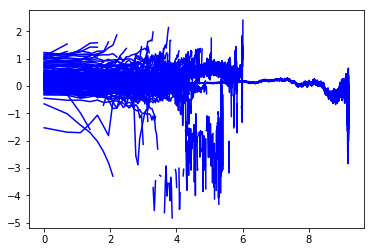

In [28]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

In [29]:
densities = []
        
x_begin = 0
y_begin = 0

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:
        a = arr_10kb[x_begin:x1, y_begin:y1]
        a[a == -np.inf] = 0

        x_begin = x2
        y_begin = y2

        density = calc_densities_sum(a)
        densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


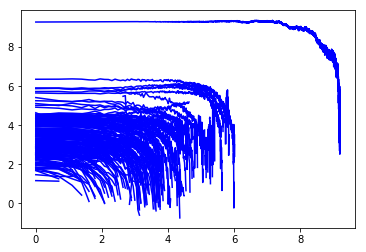

In [30]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

#### scaling in one size

In [31]:
densities = []

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    original_image = arr_10kb[x1:y1, x2:y2]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    loop = resize_image
    
    density = calc_densities_mean(loop)
    densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


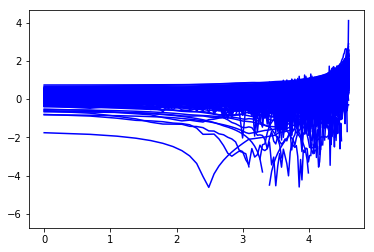

In [32]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


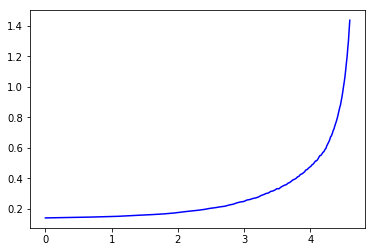

In [33]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/mean_density_loops_mean_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()

In [34]:
densities = []

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    original_image = arr_10kb[x1:y1, x2:y2]
    resize_image = resize_image_arr(original_image, width, height)
    
    resize_image[resize_image == -np.inf] = 0
    resize_image = np.nan_to_num(resize_image) 
    
    loop = resize_image
    
    density = calc_densities_sum(loop)
    densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


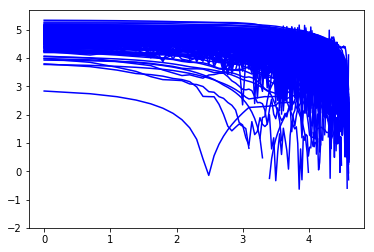

In [35]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


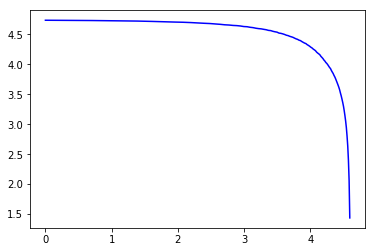

In [36]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/mean_density_loops_sum_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()

#### between loops

In [37]:
densities = []
        
x_begin = 0
y_begin = 0

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:        
        original_image = arr_10kb[x_begin:x1, y_begin:y1]
        resize_image = resize_image_arr(original_image, width, height)
    
        resize_image[resize_image == -np.inf] = 0
        resize_image = np.nan_to_num(resize_image) 
    
        a = resize_image

        x_begin = x2
        y_begin = y2

        density = calc_densities_mean(a)
        densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


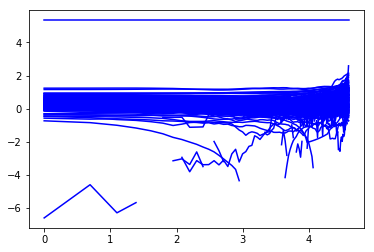

In [38]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


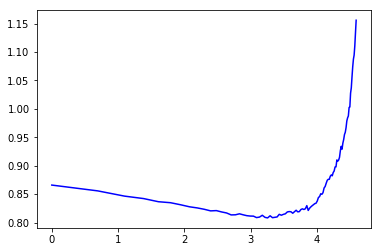

In [39]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/mean_density_btw_mean_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()

In [40]:
densities = []
        
x_begin = 0
y_begin = 0

width , height = loop_new_size, loop_new_size
resize_image_sum = np.zeros(shape=(width,height))

for idx, row in loops.iterrows():
    
    # the coordinates of the upstream locus corresponding to the peak pixel
    x1 = int(row['x1']/resolution)
    x2 = int(row['x2']/resolution)

    # the coordinates of the downstream locus corresponding to the peak pixel
    y1 = int(row['y1']/resolution)
    y2 = int(row['y2']/resolution)
    
    if x_begin < x1 and y_begin < y1:        
        original_image = arr_10kb[x_begin:x1, y_begin:y1]
        resize_image = resize_image_arr(original_image, width, height)
    
        resize_image[resize_image == -np.inf] = 0
        resize_image = np.nan_to_num(resize_image) 
    
        a = resize_image

        x_begin = x2
        y_begin = y2

        density = calc_densities_sum(a)
        densities.append(density)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


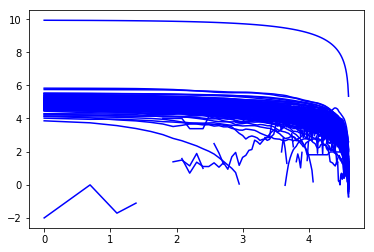

In [41]:
fig = plt.figure()
ax = plt.axes()

for density in densities:
    plt.plot(np.log(range(density.shape[0])), np.log(density), 'b');
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


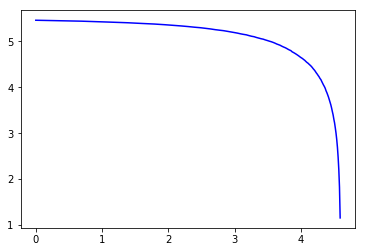

In [42]:
fig = plt.figure()
ax = plt.axes()

sum_density = densities[0]

for density in densities:
    sum_density = sum_density + density
    
mean_density = sum_density/len(densities)

np.save('arrs/densities/mean_density_btw_sum_rao', mean_density)

plt.plot(np.log(range(mean_density.shape[0])), np.log(mean_density), 'b');
plt.show()